In [1]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()

print(bucket)

sagemaker-us-east-1-011113936377


In [2]:
!aws s3 sync s3://{bucket}/wsb/data/ data/

In [3]:
import sys
import re
import os
import json
import datetime
import pytz
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc.lower()) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t) and t.upper() not in allsymbols]


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
ET = pytz.timezone('US/Eastern')

ignorelist=["DD","FREE","CASH","ON","I"]
allsymbols=[]
with open("allsymbols.txt") as fh:
    allsymbols=fh.readlines()
allsymbols = [x.strip() for x in allsymbols]

dt=datetime.timedelta(days=7)

wnl = WordNetLemmatizer()


In [6]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [7]:
import datetime

stockdata={}
def getstockprice(symbol,date):
    if symbol not in stockdata:
        with open("stockprices/"+symbol,"r") as fh:
            data=json.load(fh)
        stockdata[symbol]={}
        for stockday in data:
            indate=datetime.datetime.strptime(stockday["begins_at"],"%Y-%m-%dT%H:%M:%SZ").date()
            stockdata[symbol][indate]=stockday
    today=datetime.date.today()
    while True:
        #print(date)
        if date in stockdata[symbol]:
            return float(stockdata[symbol][date]['close_price'])
        date=date+datetime.timedelta(days=1)
        if date>today:
            break
    raise Exception("No stock data found")
    return None
            

In [8]:
files = os.listdir("data/")

foundsymbols=[]
relevant_posts = []
i=0
for file in files:
  if(round(i/100,0)==i/100):
        update_progress(i / len(files))  
  with open("data/"+file,"r") as fh:
    try:
        data=json.load(fh)
        text = (data["title"]+" "+data["selftext"]).replace('\"','').replace('\'','')
        allmatches=[]
        matches=re.findall('\W*([A-Z][A-Z\.]{0,3})\W',text)
        for submatch in matches:
            allmatches.append({submatch:submatch})
            #pass
        matches2=re.findall('\W*(\$[a-z\.]{1,4})',text)
        for submatch in matches2:
            allmatches.append({submatch.upper()[1:]:submatch})
        thesesymbols=[]
        #print(allmatches)
        for submatch in allmatches:
            symbol=list(submatch.keys())[0]
            #print(submatch.keys())
            #print(symbol)
            #print([list(x.keys())[0] for x in thesesymbols])
            if symbol in allsymbols and symbol not in [list(x.keys())[0] for x in thesesymbols] and symbol not in ignorelist:
                thesesymbols.append(submatch)
                if symbol not in foundsymbols:
                    foundsymbols.append(symbol)
        if len(thesesymbols)>0:
            relevant_posts.append({"data":data,"symbols":thesesymbols})
            #print(thesesymbols)
    except Exception as err:
      print("Error with",file)
      raise(err)
  i+=1
    

  #if i>1000:
  #  break



Progress: [####################] 99.9%


In [9]:
print(len(foundsymbols))
with open("foundsymbols.txt","w") as fh:
    fh.write("\n".join(foundsymbols))
foundsymbols

3661


['TSLA',
 'B',
 'AMZN',
 'COST',
 'C',
 'LULU',
 'AMD',
 'FB',
 'PTON',
 'AAPL',
 'GOLD',
 'ROKU',
 'NFLX',
 'DIS',
 'HAS',
 'GOOD',
 'ONCY',
 'SPCE',
 'AMC',
 'KR',
 'PM',
 'ABC',
 'X',
 'Y',
 'CYBR',
 'PANW',
 'RPD',
 'EDIT',
 'DTE',
 'DCOM',
 'AT',
 'ACB',
 'THC',
 'MU',
 'IP',
 'AG',
 'GILD',
 'TJX',
 'HTZ',
 'TVTY',
 'DGX',
 'QQQ',
 'TA',
 'BYND',
 'POST',
 'SR',
 'NIO',
 'RING',
 'A',
 'NEW',
 'IT',
 'FOSL',
 'BK',
 'PINS',
 'KRTX',
 'OVID',
 'DOW',
 'SBUX',
 'VC',
 'MCD',
 'MSFT',
 'WMT',
 'SNAP',
 'PECK',
 'HUGE',
 'GDP',
 'WELL',
 'CDC',
 'BA',
 'V',
 'FAT',
 'NOC',
 'LMT',
 'RH',
 'AAL',
 'GO',
 'SDC',
 'ALGN',
 'ONE',
 'ATVI',
 'M',
 'CEO',
 'K',
 'ALLY',
 'SIX',
 'CME',
 'AM',
 'LIVE',
 'FIT',
 'SWBI',
 'EC',
 'F',
 'CRM',
 'BAC',
 'CTO',
 'PEP',
 'UAL',
 'DAL',
 'JNJ',
 'PCG',
 'E',
 'PLUS',
 'AMTD',
 'TTD',
 'DEA',
 'CBD',
 'CCL',
 'ARE',
 'OUT',
 'G',
 'BMO',
 'IONS',
 'FOR',
 'HAL',
 'INFY',
 'KO',
 'SYF',
 'NDAQ',
 'NEE',
 'ERIC',
 'DPZ',
 'LUV',
 'UNP',
 'AXP',
 'SNY'

In [10]:
#split into multiple corpus here


import random
random.shuffle(relevant_posts)
n_train = int(0.8 * len(relevant_posts))

training_posts = relevant_posts[:n_train]
test_posts = relevant_posts[n_train:]
val_posts = test_posts[:n_train//2]
test_posts = test_posts[n_train//2:]

vocab_input = [t["data"]["title"]+" "+t["data"]["selftext"] for t in training_posts]
print(len(relevant_posts),n_train)

34504 27603


In [11]:
test_posts = relevant_posts[n_train:]
print(n_train,n_train//2)
test_posts = relevant_posts[n_train:]
print(len(test_posts))
print(len(test_posts)//2)
val_posts = test_posts[:len(test_posts)//2]
test_posts = test_posts[len(test_posts)//2:]
len(test_posts)

27603 13801
6901
3450


3451

In [12]:
vocab_size=2500

vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english', tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)

vectors = vectorizer.fit_transform(vocab_input)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


vocab size: 2500


In [13]:
vocab_list

['ability',
 'able',
 'absolute',
 'absolutely',
 'accept',
 'access',
 'according',
 'account',
 'accounting',
 'accurate',
 'acquire',
 'acquired',
 'acquisition',
 'action',
 'active',
 'actively',
 'activision',
 'activity',
 'actual',
 'actually',
 'ad',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'additionally',
 'address',
 'adj',
 'adjusted',
 'administration',
 'advance',
 'advanced',
 'advantage',
 'advertising',
 'advice',
 'advisor',
 'af',
 'affect',
 'affected',
 'afford',
 'after-hours',
 'after-market',
 'afternoon',
 'agency',
 'aggressive',
 'agree',
 'agreed',
 'agreement',
 'ah',
 'ahead',
 'aid',
 'aircraft',
 'airline',
 'aka',
 'alert',
 'algos',
 'alibaba',
 'alive',
 'all-time',
 'allow',
 'allowed',
 'allowing',
 'allows',
 'alpha',
 'alphabet',
 'alright',
 'alternative',
 'amazing',
 'amazon',
 'america',
 'american',
 'ameritrade',
 'amid',
 'am|\\',
 'analysis',
 'analyst',
 'and/or',
 'animal',
 'announce',
 'announced',
 'announcement',
 'a

In [14]:
threshhold=.05
lt = LemmaTokenizer()
from scipy.sparse import csr_matrix

def calculateData(post):
    #print(post)
    data=post["data"]
    thesesymbols=post["symbols"]
    text = data["title"]+" "+data["selftext"]
    texttokens=lt(text)
    #print(text,texttokens)
    #print("Symbol:",thesesymbols)
    wordvector=[]
    for word in vocab_list:
        wordvector.append(texttokens.count(word))
    returnarray=[]
    for symbolmap in thesesymbols:
        symbol=list(symbolmap.keys())[0]
        try:
        #if True:
            
                #if word in texttokens:
                    #print(word)
                #    wordvector.append(1)
                #else:
                #    wordvector.append(0)
                #locword = text.find(word)
                #distance=0
                #if locword>-1:
                #    distance=abs(text.find(symbolmap[symbol])-locword)
                #    print(symbol,word,distance)
                #wordvector.append(distance)
            #print(symbol,wordvector)
            posttime=[0,0,0,0]
            start=ET.localize(datetime.datetime.fromtimestamp(data["created_utc"]))
            if start.hour>=21:
                posttime[0]=1
            elif start.hour < 5:
                posttime[0]=1
            elif start.hour < 9:
                posttime[1]=1
            elif start.hour < 16:
                posttime[2]=1
            else:
                posttime[3]=1
            if start.hour>=9:
                start=start+datetime.timedelta(days=1)
            start=start.replace(hour=9,minute=0,second=0,microsecond=0).date()
            end=start+dt
            startprice=getstockprice(symbol,start)
            endprice=getstockprice(symbol,end)
            #print(start,end,history)
            delta=(endprice-startprice)/startprice
            if delta<=-1*(threshhold):
                result=1
            elif delta>=threshhold:
                result=2
                #print(symbol,delta,result,wordvector)
            else:
                result=0
            returnarray.append([result]+posttime+wordvector)
        except Exception as err:
            print("Error with",symbol,", skipping this one:",err)
    return returnarray


def calculateVectors(posts):
    vector = []
    i=0
    for post in posts:
        #try:
        if True:
           response=calculateData(post)
           for row in response:
                vector.append(row)
        #except Exception as err:
        #    print("Error",err)
        #    pass
        i+=1
        if(round(i/100,0)==i/100):
            update_progress(i / len(posts))
    vector=np.array(vector).astype('float32')
    return vector

training_vector = calculateVectors(training_posts)
test_vector = calculateVectors(test_posts)
val_vector = calculateVectors(val_posts)

Progress: [####################] 98.6%


In [15]:
import pandas as pd
pd.DataFrame(training_vector, columns=["Output"]+["21-4","5-8","9-15","16-20"]+vocab_list)

,Output,21-4,5-8,9-15,16-20,ability,able,absolute,absolutely,accept,...,yolos,york,young,youtube,yoy,yr/yr,ytd,zero,zone,zoom
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69700,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69701,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69702,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69703,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
training_vector[0:1]

array([[1., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
%%time

import struct
import io
import boto3

prefix='wsb-xgboost'
region = boto3.Session().region_name
 
def to_libsvm(f, labels, values):
     f.write(bytes('\n'.join(
         ['{} {}'.format(label, ' '.join(['{}:{}'.format(i + 1, el) for i, el in enumerate(vec)])) for label, vec in
          zip(labels, values)]), 'utf-8'))
     return f


def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(partition_name, partition):
    labels = [t.tolist() for t in partition[:,0]]
    vectors = [t.tolist() for t in partition[:,1:]]
    num_partition = 5                                 # partition file into 5 parts
    partition_bound = int(len(labels)/num_partition)
    for i in range(num_partition):
        f = io.BytesIO()
        to_libsvm(f, labels[i*partition_bound:(i+1)*partition_bound], vectors[i*partition_bound:(i+1)*partition_bound])
        f.seek(0)
        key = "{}/{}/examples{}".format(prefix,partition_name,str(i))
        url = 's3n://{}/{}'.format(bucket, key)
        print('Writing to {}'.format(url))
        write_to_s3(f, bucket, key)
        print('Done writing to {}'.format(url))

def download_from_s3(partition_name, number, filename):
    key = "{}/{}/examples{}".format(prefix,partition_name, number)
    url = 's3n://{}/{}'.format(bucket, key)
    print('Reading from {}'.format(url))
    s3 = boto3.resource('s3', region_name = region)
    s3.Bucket(bucket).download_file(key, filename)
    #try:
    #    s3.Bucket(bucket).download_file(key, 'mnist.local.test')
    #except botocore.exceptions.ClientError as e:
    #    if e.response['Error']['Code'] == "404":
    #        print('The object does not exist at {}.'.format(url))
    #    else:
    #        raise        
        
def convert_data():
    partitions = [('train', training_vector), ('validation', val_vector), ('test', test_vector)]
    for partition_name, partition in partitions:
        print('{}: {} {}'.format(partition_name, partition[:,0].shape, partition[:,1:].shape))
        upload_to_s3(partition_name, partition)

CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 13.3 ms


In [41]:
val_vector[:,1:].shape

(7805, 2504)

In [18]:
%%time

convert_data()

train: (69705,) (69705, 2504)
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples0
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples0
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples1
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples1
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples2
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples2
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples3
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples3
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples4
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/train/examples4
validation: (7805,) (7805, 2504)
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/validation/examples0
Done writing to s3n://sagemaker-us-east-1-0111139

In [19]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').


In [42]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:merror",
      "Type": "Minimize"
    }
  }

In [43]:
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/xgboost".format(bucket,prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 2,   
        "InstanceType": "ml.m4.10xlarge",
        "VolumeSizeInGB": 5
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "merror",
      "num_round": "100",
      "objective": "multi:softmax",
      "num_class": "3",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

In [45]:
from time import gmtime, strftime

sm = boto3.Session(region_name=region).client('sagemaker')

tuning_job_name = "MyTuningJob" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
sm.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:011113936377:hyper-parameter-tuning-job/mytuningjob2020-07-17-21-42-31',
 'ResponseMetadata': {'RequestId': 'ba77d4ea-72b6-49e9-901e-4719adba2cb6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ba77d4ea-72b6-49e9-901e-4719adba2cb6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '131',
   'date': 'Fri, 17 Jul 2020 21:42:31 GMT'},
  'RetryAttempts': 0}}

In [20]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

#Ensure that the train and validation data folders generated above are reflected in the "InputDataConfig" parameter below.
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/"+ prefix + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.10xlarge",
        "VolumeSizeInGB": 5
    },
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "silent":"0",
        "objective": "multi:softmax",
        "num_class": "3",
        "num_round": "30"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        }
    ]
}

In [21]:

import copy

#single machine job params
single_machine_job_name = 'wsb-xgboost-classification' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", single_machine_job_name)

single_machine_job_params = copy.deepcopy(common_training_params)
single_machine_job_params['TrainingJobName'] = single_machine_job_name
single_machine_job_params['OutputDataConfig']['S3OutputPath'] = bucket_path + "/"+ prefix + "/xgboost-single"
single_machine_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is: wsb-xgboost-classification2020-07-17-20-18-44


In [59]:
%%time



sm.create_training_job(**single_machine_job_params)

status = sm.describe_training_job(TrainingJobName=single_machine_job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=single_machine_job_name)
status = sm.describe_training_job(TrainingJobName=single_machine_job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=single_machine_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 117 ms, sys: 8.07 ms, total: 125 ms
Wall time: 4min


In [60]:
%%time
import boto3
from time import gmtime, strftime

model_name=single_machine_job_name + '-mod'
print(model_name)

info = sm.describe_training_job(TrainingJobName=single_machine_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

wsb-xgboost-classification2020-07-15-21-28-25-mod
https://s3-us-east-1.amazonaws.com/sagemaker-us-east-1-011113936377/wsb-xgboost/xgboost-single/wsb-xgboost-classification2020-07-15-21-28-25/output/model.tar.gz
arn:aws:sagemaker:us-east-1:011113936377:model/wsb-xgboost-classification2020-07-15-21-28-25-mod
CPU times: user 9.46 ms, sys: 32 µs, total: 9.49 ms
Wall time: 407 ms


In [61]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2020-07-15-21-32-26
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:011113936377:endpoint-config/demo-xgboostendpointconfig-2020-07-15-21-32-26


In [62]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2020-07-15-21-32-26
arn:aws:sagemaker:us-east-1:011113936377:endpoint/demo-xgboostendpoint-2020-07-15-21-32-26
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:011113936377:endpoint/demo-xgboostendpoint-2020-07-15-21-32-26
Status: InService
CPU times: user 132 ms, sys: 7.99 ms, total: 140 ms
Wall time: 8min 1s


In [63]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)

In [64]:
download_from_s3('test', 0, 'wsb.local.test') # reading the first part file within test

Reading from s3n://sagemaker-us-east-1-011113936377/wsb-xgboost/test/examples0


In [65]:
!head -1 wsb.local.test > wsb.single.test

In [66]:
%%time
import json

file_name = 'wsb.single.test' #customize to your test file 'mnist.single.test' if use the data above

with open(file_name, 'r') as f:
    payload = f.read()

response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/x-libsvm', 
                                   Body=payload)
result = response['Body'].read().decode('ascii')
print('Predicted label is {}.'.format(result))

Predicted label is 0.0.
CPU times: user 17.4 ms, sys: 4.07 ms, total: 21.5 ms
Wall time: 184 ms


In [67]:
import sys
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read().decode('ascii')
    preds = [float(num) for num in result.split(',')]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    for offset in range(0, items, batch_size):
        arrs.extend(do_predict(data[offset:min(offset+batch_size, items)], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [68]:
%%time
import json

file_name = 'wsb.local.test'
with open(file_name, 'r') as f:
    payload = f.read().strip()

labels = [float(line.split(' ')[0]) for line in payload.split('\n')]
test_data = payload.split('\n')
preds = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')

print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

.................
error rate=0.456654
CPU times: user 472 ms, sys: 53.5 ms, total: 526 ms
Wall time: 12.9 s


In [69]:
preds[0:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [70]:
labels[0:10]

[0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0]

In [71]:
import numpy
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([10, 10], numpy.int32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[int(predicted), int(actual)] += 1
    
    return error, confusions

Test error: 45.7%


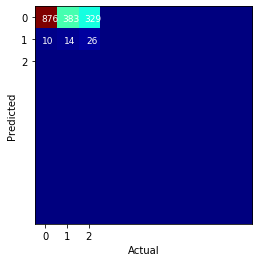

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline  

NUM_LABELS = 3  # change it according to num_class in your dataset
test_error, confusions = error_rate(numpy.asarray(preds), numpy.asarray(labels))
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

In [73]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'd4b5d553-541d-4d77-ac54-9173c84f2eeb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd4b5d553-541d-4d77-ac54-9173c84f2eeb',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 15 Jul 2020 21:40:41 GMT'},
  'RetryAttempts': 0}}